# Building a Wavenet

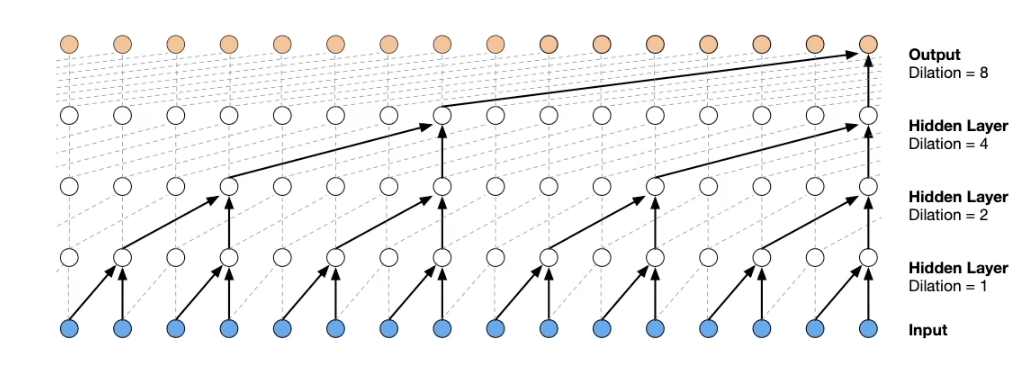

We're going to be implementing [this 2016 paper](https://arxiv.org/abs/1609.03499) from DeepMind

In [1]:
#Imports
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt #for making figures
%matplotlib inline

In [2]:
#Read in all the words
words = open('../data/names.txt').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
#Build stoi and itos lookup tables
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
import random
random.seed(42)
random.shuffle(words)

In [5]:
block_size = 8

def build_dataset(words):
    X, Y = [], []
    for w in words:

        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] #crop and append
        # print('\n')
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [53]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 #Kaiming initialization
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            if x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) #batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) #normalize to zero mean unit variance
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
        
    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
    def __call__(self, x):
        B, T, E = x.shape
        x = x.view(B, T//self.n, E*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

        
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
        
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [8]:
torch.manual_seed(42); #for reproducibility

`n_hidden` used to be 200 but we drop it to 68 to match the total number of parameters as before. Giving the network more parameters is sort of like cheating when comparing the efficacy of two architectures. What we care about is closer to efficacy per parameter. 

In [68]:
n_embed = 10 #dimensionality of character embeddings
n_hidden = 68 #dimensionality of hidden layers
g = torch.Generator().manual_seed(6789998212) 


model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 #last layer: make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
    p.requires_grad = True

22397


### Scratch space

In [55]:
#Let's look at a batch of size 4...
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  3,  9],
        [ 0,  0,  0,  0,  0, 19,  1, 21],
        [ 0,  0,  0,  1, 18, 20,  8, 21],
        [ 0,  0,  0,  0,  0,  0,  0, 11]])

In [56]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [57]:
#Embed the characters in Xb individually ([0,26])x8 -> (R^10)x8
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [58]:
#Glue individual character embedding spaces together at the origin to create one large space (R^10)x8 -> R^80
model.layers[1].out.shape

torch.Size([4, 4, 20])

In [59]:
#Affine transform the joint embedding into a much larger space, R^80 -> R^200
model.layers[2].out.shape

torch.Size([4, 4, 68])

Right now, the flattening is happening all in one go:

`(1) (2) (3) (4) (5) (6) (7) (8) -> (1 2 3 4 5 6 7 8)`

What we'd rather have is

`(1) (2) (3) (4) (5) (6) (7) (8) -> (1 2) (3 4) (5 6) (7 8)`

`(1 2) (3 4) (5 6) (7 8) -> (1 2 3 4) (5 6 7 8)`

`(1 2 3 4) (5 6 7 8) -> (1 2 3 4 5 6 7 8)`

### Asside - Python Indexing Syntax
Remember that python indexing is `[start:end:step]`

In [60]:
list(range(10))[::2]

[0, 2, 4, 6, 8]

In [61]:
list(range(10))[1::2]

[1, 3, 5, 7, 9]

We can use this to turn our set of 8 10D embeddings into a set of 4 20D embedding with `torch.cat`

In [62]:
e = torch.randn(4,8,10)
explicit_concat = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2) #concat along the embedding index
explicit_concat.shape

torch.Size([4, 4, 20])

But again, `view` does this more performantly

In [63]:
(e.view(4,4,20) == explicit_concat).all()

tensor(True)

### What is our old implementation of batchnorm doing to our new tensors?

In [64]:
e = torch.randn(32,4,68) #Noise the shape of the linear layer output
emean = e.mean(0, keepdim=True)
evar = e.mean(0, keepdim=True)
ehat = (e - emean) / torch.sqrt(evar + 1e-5)
ehat.shape

torch.Size([32, 4, 68])

In [65]:
e.shape, emean.shape, evar.shape, ehat.shape

(torch.Size([32, 4, 68]),
 torch.Size([1, 4, 68]),
 torch.Size([1, 4, 68]),
 torch.Size([32, 4, 68]))

In [66]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

The 1 index accounts for 4 different vector spaces (one for each bigram in the sequence). Since we're only averaging over the 0 index, we're not blending the information across those spaces. But we want to (WHY?). We want to treat those separate universes as a batch dimension. 

He says that by blending those means you get means that are more stable (since they're derived from a larger samples).

IDK i'm honestly not convinced that this should necessarily be an improvement.

### Training

In [69]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
update_ratios = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

    #forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 #learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3068
  10000/ 200000: 2.1716
  20000/ 200000: 2.0062
  30000/ 200000: 1.7404
  40000/ 200000: 1.8286
  50000/ 200000: 1.9519
  60000/ 200000: 2.1773
  70000/ 200000: 2.3231
  80000/ 200000: 1.8055
  90000/ 200000: 2.0283
 100000/ 200000: 2.4963
 110000/ 200000: 1.9088
 120000/ 200000: 2.0062
 130000/ 200000: 2.1736
 140000/ 200000: 2.1217
 150000/ 200000: 1.9807
 160000/ 200000: 2.0517
 170000/ 200000: 1.8898
 180000/ 200000: 2.0898
 190000/ 200000: 2.2084


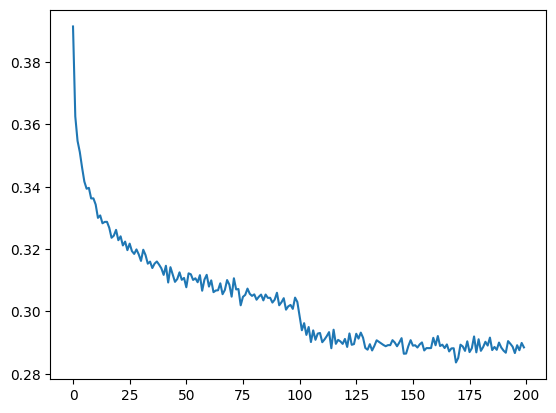

In [70]:
# A better loss plot. The step is where learning rate decay kicks in :')
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [71]:
for layer in model.layers:
    layer.training = False

This is too thick. This indicates the minibatch sizes should be larger. Larger sample -> less variance in your estimate of the loss.

In [72]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9231548309326172
val 2.026824474334717


In [ ]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits,dim=1)
        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        #shift the context window and append the sample
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the specail '.' token, stop
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

### Preview: Convolutions

In [73]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [74]:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

### Numbers to beat
- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix bug in batchnorm: train 1.912, val 2.022
- scale up the network: n_embd 24, n _hidden 128 (76K params): train 1.769, val 1.993

It's not obvious that we have the embedding dimensions right, learning hyperparameters right, or initializations right. It's not even obvious that this hierarchical model beats a linear model or even single layer model of an equivalent number of parameters.